In [1]:
!pip install xarray==0.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 594 kB 4.3 MB/s 
  Attempting uninstall: xarray
    Found existing installation: xarray 2022.12.0
    Uninstalling xarray-2022.12.0:
      Successfully uninstalled xarray-2022.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.4.0 requires xarray>=0.16, but you have xarray 0.13.0 which is incompatible.
arviz 0.12.1 requires xarray>=0.16.1, but you have xarray 0.13.0 which is incompatible.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray
from numba import jit

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
cd '/content/drive/MyDrive/StrongWinds'

/content/drive/MyDrive/StrongWinds


In [5]:
!ls

 elevation.gdoc   wind.nc   ГПХ2	        Презенташки
 elev.nc	  ГПХ1	   'Отчет о НИР.gdoc'


In [29]:
elev_xarray = xarray.load_dataset('elev.nc', decode_times=False)
wind_xarray = xarray.load_dataset('wind.nc', decode_times=False)
elev_xarray = elev_xarray.__xarray_dataarray_variable__
wind_xarray = wind_xarray.__xarray_dataarray_variable__

In [56]:
def reduce_to_area(data_arr: xarray.DataArray, lat_min: float = 24, lat_max: float = 45, lon_min: float = 252, lon_max: float = 270) -> xarray.DataArray:
    """
    Reduces the area to the input frames +-1.5 on latitude axis and +-2 on longitude axis.
    """
    output = data_arr.sel(lat=slice(lat_min - 1.5, lat_max + 1.5), lon=slice(lon_min - 2, lon_max + 2))
    output.data = np.float64(output.data)

    return output

In [57]:
def slow_mean_res_incr(X_elev=X_elev, Y_elev=Y_elev,
                       X_wind=X_wind, Y_wind=Y_wind, 
                       elev_data=elev_data, 
                       etalon_data=etalon_data):
    
    x=0 
    y=0
    k_start = 0
    i_start = 0
    for k in range(len(Y_elev)):
        if y<len(Y_wind) and Y_elev[k] > Y_wind[y]:
            k_end = k
            for i in range(len(X_elev)):
                if x<len(X_wind) and X_elev[i] > X_wind[x] and i>0:
                    i_end = i
                    val = np.mean(elev_data[k_start:k_end, i_start:i_end])
                    etalon_data[y,x] = val
                    x+=1
                    i_start = i
            x=0
            y+=1
            k_start = k
            i_start = 0
    return etalon_data


In [58]:
@jit
def fast_mean_res_incr(X_elev=X_elev, Y_elev=Y_elev,
                       X_wind=X_wind, Y_wind=Y_wind, 
                       elev_data=elev_data, 
                       etalon_data=etalon_data):
    
    x=0 
    y=0
    k_start = 0
    i_start = 0
    for k in range(len(Y_elev)):
        if y<len(Y_wind) and Y_elev[k] > Y_wind[y]:
            k_end = k
            for i in range(len(X_elev)):
                if x<len(X_wind) and X_elev[i] > X_wind[x] and i>0:
                    i_end = i
                    val = np.mean(elev_data[k_start:k_end, i_start:i_end])
                    etalon_data[y,x] = val
                    x+=1
                    i_start = i
            x=0
            y+=1
            k_start = k
            i_start = 0
    return etalon_data

In [68]:
Size = []
T_slow = []
T_fast = []

for i in range(1, 19):
  elev_xarray = xarray.load_dataset('elev.nc', decode_times=False)
  wind_xarray = xarray.load_dataset('wind.nc', decode_times=False)
  elev_xarray = elev_xarray.__xarray_dataarray_variable__
  wind_xarray = wind_xarray.__xarray_dataarray_variable__

  Size.append(i)

  elev_xarray = reduce_to_area(elev_xarray, lat_min = 24, lat_max = 24 + i, lon_min = 252, lon_max = 252 + i)
  wind_xarray = reduce_to_area(wind_xarray, lat_min = 24, lat_max = 24 + i, lon_min = 252, lon_max = 252 + i)

  Y_elev = elev_xarray.lat.data
  X_elev = elev_xarray.lon.data
  Y_wind = wind_xarray.lat.data
  X_wind = wind_xarray.lon.data
  elev_data = elev_xarray.data
  etalon_data = np.zeros(wind_xarray[0,:,:].data.shape)

  slow_refined_xarray = wind_xarray[0,:,:].copy()
  t = %timeit -o slow_refined_xarray.data = slow_mean_res_incr(X_elev=X_elev, Y_elev=Y_elev, X_wind=X_wind, Y_wind=Y_wind, elev_data=elev_data, etalon_data=etalon_data)
  T_slow.append(t.best*1000)

  fast_refined_xarray = wind_xarray[0,:,:].copy()
  t = %timeit -o fast_refined_xarray.data = fast_mean_res_incr(X_elev=X_elev, Y_elev=Y_elev, X_wind=X_wind, Y_wind=Y_wind, elev_data=elev_data, etalon_data=etalon_data)
  T_fast.append(t.best*1000)

8.11 ms ± 644 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
723 µs ± 188 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.9 ms ± 869 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
925 µs ± 6.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
17.6 ms ± 690 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.34 ms ± 19.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
22 ms ± 4.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.78 ms ± 365 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
31.3 ms ± 5.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3 ms ± 169 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
38.2 ms ± 4.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.04 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
64.1 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.26 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
53.8 ms ± 4

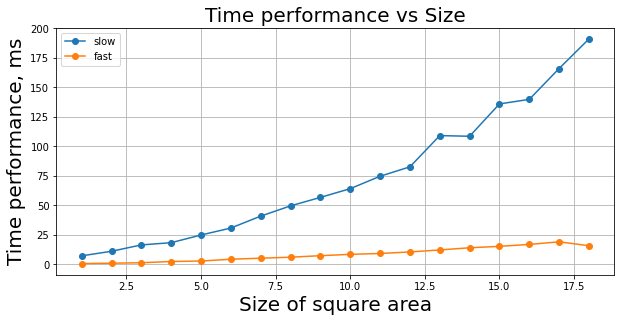

In [77]:
fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(2, 1, 2)
ax.set_xlabel('Size of square area', fontsize = 20)
ax.set_ylabel('Time performance, ms', fontsize = 20)
plt.title('Time performance vs Size', fontsize = 20)
ax.grid(True)
plt.plot(Size, T_slow, marker = 'o', label='slow')
plt.plot(Size, T_fast, marker = 'o', label='fast')
plt.legend()
plt.show()

In [80]:
elev_xarray = xarray.load_dataset('elev.nc', decode_times=False)
wind_xarray = xarray.load_dataset('wind.nc', decode_times=False)
elev_xarray = elev_xarray.__xarray_dataarray_variable__
wind_xarray = wind_xarray.__xarray_dataarray_variable__

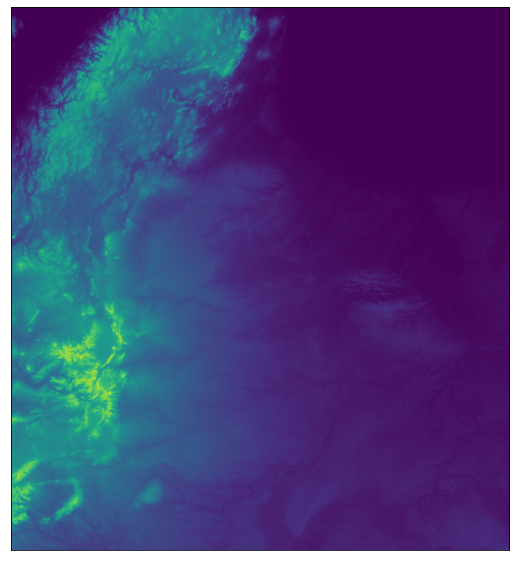

In [82]:
plt.figure(figsize=(10,10))
plt.imshow(elev_xarray.data)
plt.xticks([])
plt.yticks([])
plt.show()

In [83]:
Y_elev = elev_xarray.lat.data
X_elev = elev_xarray.lon.data
Y_wind = wind_xarray.lat.data
X_wind = wind_xarray.lon.data
elev_data = elev_xarray.data
etalon_data = np.zeros(wind_xarray[0,:,:].data.shape)

slow_refined_xarray = wind_xarray[0,:,:].copy()
slow_refined_xarray.data = slow_mean_res_incr(X_elev=X_elev, Y_elev=Y_elev, X_wind=X_wind, Y_wind=Y_wind, elev_data=elev_data, etalon_data=etalon_data)

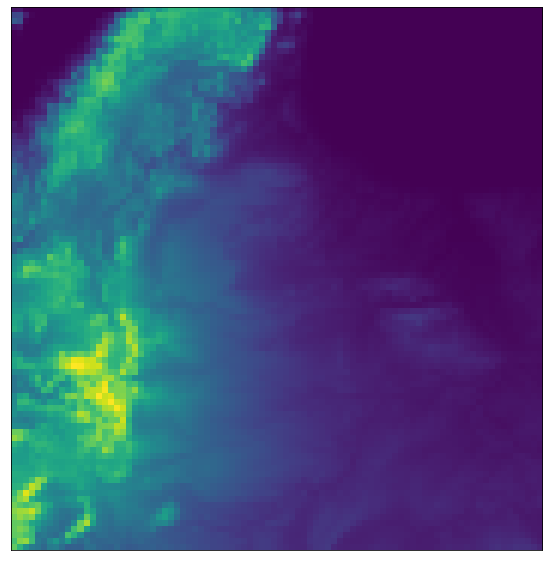

In [84]:
plt.figure(figsize=(10,10))
plt.imshow(slow_refined_xarray.data)
plt.xticks([])
plt.yticks([])
plt.show()